In [1]:
!pwd

/Volumes/GoogleDrive/My Drive/01_HEEH_design/code


1. analyze sequence diversity, determine how much % similarity bw designs we want in our order.


In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import difflib
from difflib import SequenceMatcher

In [ ]:
### need 4 #s: 
median pairwise identity of all TESTED rd5, 
median pairwise identity of all STABLE rd5, 

median pairwise identity of all TESTED rd6 (3986 set) after filtering), 
median pairwise identity of all STABLE rd6.

## Import and prepare data


In [2]:
# load data
rd5 = pd.read_csv('../2022_HEEH_manuscript/data/stability_scores/rd5_stability_scores.csv')
rd6 = pd.read_csv('../2022_HEEH_manuscript/data/stability_scores/rd6_stability_scores_fig4b-g.csv')

In [3]:
# add column to separate designs from scrambles
rd6['cat'] = ['scr' if i[-2:] == "hp" else "design" for i in rd6['name']]

# rename column
rd6.rename(columns={'protein_sequence_c':'sequence'}, inplace=True)

In [4]:
# create df with just designs
rd5 = rd5.query('cat=="design"')
rd6 = rd6.query('cat=="design"')

# create df with just stable designs
rd5_stable = rd5.query('stabilityscore>1')
rd6_stable = rd6.query('stabilityscore>1')

In [5]:
len(rd6_stable)

1016

In [6]:
rd5_stable

,name,counts0_t,counts1_t,counts2_t,counts3_t,counts4_t,counts5_t,counts6_t,downsamp_counts1_t,downsamp_counts2_t,...,ec50_95ci_c,ec50_c,full_protein_sequence_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,ec50_95ci,sequence,cat
0,HEEH_TK_rd5_0001.pdb,143,145,161,312,201,45,14,71,106,...,0.0,4.122306,GGGSASHMSLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRL...,-0.076770,4.199077,2.003469,1.913482,0.0,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,design
1,HEEH_TK_rd5_0002.pdb,24,40,29,71,49,86,129,19,19,...,0.0,5.117518,GGGSASHMDIEELIRLLEEALRKNQSITILGFEVRHEEEFEHLLRI...,0.459088,4.658430,2.222636,2.222636,0.5,DIEELIRLLEEALRKNQSITILGFEVRHEEEFEHLLRILRELL,design
2,HEEH_TK_rd5_0003.pdb,232,351,323,549,567,982,1012,172,214,...,0.0,5.361894,GGGSASHMTLEELLKEAERLLREGHSLHIAGIEIRDEEELRKAFEW...,-0.245634,5.607528,2.675471,2.501998,0.1,TLEELLKEAERLLREGHSLHIAGIEIRDEEELRKAFEWLRRWL,design
3,HEEH_TK_rd5_0004.pdb,97,226,148,300,364,629,668,110,98,...,0.0,5.015991,GGGSASHMTEEDLLELLREALRKGEEITIAGIRVTNEEAFEELLRW...,0.738729,4.277262,2.040773,1.988258,0.1,TEEDLLELLREALRKGEEITIAGIRVTNEEAFEELLRWLEKWI,design
4,HEEH_TK_rd5_0005.pdb,184,273,241,450,386,685,682,133,160,...,0.0,4.999597,GGGSASHMTIEELLREIEDLLRKGIEFHWAGITIKTEEEARKILEH...,0.819071,4.180526,1.994618,1.994618,0.1,TIEELLREIEDLLRKGIEFHWAGITIKTEEEARKILEHLRRLL,design
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,HEEH_TK_rd5_5975.pdb,5,10,19,22,32,4,0,4,12,...,0.3,5.649045,GGGSASHMDLEEIKRIIDEALEKGEDITIAGIRITTEEEAKKAKEW...,1.890061,3.758984,1.793491,1.217251,0.5,DLEEIKRIIDEALEKGEDITIAGIRITTEEEAKKAKEWFEREI,design
5596,HEEH_TK_rd5_5976.pdb,14,33,12,31,7,1,0,16,7,...,0.2,3.405229,GGGSASHMHLREIEEEIKEALKRNETFHFAGIEVRSEEDLERFIRI...,0.706902,2.698327,1.287429,1.287429,0.4,HLREIEEEIKEALKRNETFHFAGIEVRSEEDLERFIRILEKRI,design
5597,HEEH_TK_rd5_5977.pdb,117,179,144,240,232,281,52,87,95,...,0.0,5.206391,GGGSASHMTLEEIEKIAKEALKRGETVRIAGFEVRDEEEARKLLEW...,-0.159216,5.365607,2.560045,2.127224,0.1,TLEEIEKIAKEALKRGETVRIAGFEVRDEEEARKLLEWFRRLF,design
5602,HEEH_TK_rd5_5983.pdb,275,362,329,665,440,71,23,177,218,...,0.0,4.216813,GGGSASHMDWEELAKKIEEAIRNGRSFHWAHIEVHTEEEARRVIEE...,1.137695,3.079118,1.469112,1.469112,0.0,DWEELAKKIEEAIRNGRSFHWAHIEVHTEEEARRVIEEIRRRI,design


In [7]:
rd5[['name', 'sequence']]

,name,sequence
0,HEEH_TK_rd5_0001.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI
1,HEEH_TK_rd5_0002.pdb,DIEELIRLLEEALRKNQSITILGFEVRHEEEFEHLLRILRELL
2,HEEH_TK_rd5_0003.pdb,TLEELLKEAERLLREGHSLHIAGIEIRDEEELRKAFEWLRRWL
3,HEEH_TK_rd5_0004.pdb,TEEDLLELLREALRKGEEITIAGIRVTNEEAFEELLRWLEKWI
4,HEEH_TK_rd5_0005.pdb,TIEELLREIEDLLRKGIEFHWAGITIKTEEEARKILEHLRRLL
...,...,...
5613,HEEH_TK_rd5_5995.pdb,SEEEIEHKLREALERGETLNILGFEVRDEEDFKWFLHIARELI
5614,HEEH_TK_rd5_5996.pdb,GREEWEEILRHAIKNNQHFKVFGLEVTDEEAARRTADWLKKFE
5615,HEEH_TK_rd5_5997.pdb,DEEELHRHIRHRLERGETVRLFGVEVRDEELAKELLEIIKRLR
5616,HEEH_TK_rd5_5998.pdb,HEEEIKKALEIARHANRSVHVAGFEIHDEEAARRALEWWKRKV


## pairwise analysis

In [8]:
def df_pairwise(df):
    ''' return df with all pariwise sequences and their design names '''
    seq_pairs_list = list(itertools.combinations(df['sequence'], 2))
    names_pairs_list = list(itertools.combinations(df['name'], 2))
    
    new_df1 = pd.DataFrame(names_pairs_list, columns = ['design1' ,'design2'])
    new_df2 = pd.DataFrame(seq_pairs_list, columns = ['seq1' ,'seq2'])
    combine_df = pd.concat([new_df1, new_df2], axis=1)
    return combine_df
    

In [9]:
rd5_pairs=df_pairwise(df=rd5)
rd6_pairs=df_pairwise(df=rd6)

In [10]:
rd5_pairs

,design1,design2,seq1,seq2
0,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0002.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,DIEELIRLLEEALRKNQSITILGFEVRHEEEFEHLLRILRELL
1,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0003.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,TLEELLKEAERLLREGHSLHIAGIEIRDEEELRKAFEWLRRWL
2,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0004.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,TEEDLLELLREALRKGEEITIAGIRVTNEEAFEELLRWLEKWI
3,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0005.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,TIEELLREIEDLLRKGIEFHWAGITIKTEEEARKILEHLRRLL
4,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0006.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,SFEELLRLLEEAWRKGTTIEILGFRVRDREEAEELLRWLRRWI
...,...,...,...,...
15778148,HEEH_TK_rd5_5996.pdb,HEEH_TK_rd5_5998.pdb,GREEWEEILRHAIKNNQHFKVFGLEVTDEEAARRTADWLKKFE,HEEEIKKALEIARHANRSVHVAGFEIHDEEAARRALEWWKRKV
15778149,HEEH_TK_rd5_5996.pdb,HEEH_TK_rd5_5999.pdb,GREEWEEILRHAIKNNQHFKVFGLEVTDEEAARRTADWLKKFE,DREEIEKIIRHAIRLGESVHVAGFTVHDEEEAEKIIKELKRII
15778150,HEEH_TK_rd5_5997.pdb,HEEH_TK_rd5_5998.pdb,DEEELHRHIRHRLERGETVRLFGVEVRDEELAKELLEIIKRLR,HEEEIKKALEIARHANRSVHVAGFEIHDEEAARRALEWWKRKV
15778151,HEEH_TK_rd5_5997.pdb,HEEH_TK_rd5_5999.pdb,DEEELHRHIRHRLERGETVRLFGVEVRDEELAKELLEIIKRLR,DREEIEKIIRHAIRLGESVHVAGFTVHDEEEAEKIIKELKRII


In [144]:
### test
#rd5_pairs_subset = rd5_pairs.iloc[:10]

In [11]:
def pairwise_identity(df):
    ''' calculate sequence identity for all pairs, returns a list of all identities '''
    seq1 = df['seq1']
    seq2 = df['seq2']
    all_identities = []
    
    for one, two in zip(seq1, seq2):
        pairwise_identity = (SequenceMatcher(a=one, b=two))
        all_identities.append(pairwise_identity.ratio())
    return(all_identities)

In [12]:
rd5_pairwise_identities = pairwise_identity(df=rd5_pairs)
rd6_pairwise_identities = pairwise_identity(df=rd6_pairs)

In [13]:
# add pairwise identity ratios to the pairs df
rd5_pairs['identity_ratio'] = rd5_pairwise_identities
rd6_pairs['identity_ratio'] = rd6_pairwise_identities

In [44]:
lenrd6_pairs

,design1,design2,seq1,seq2,identity_ratio
0,HEEH_KT_rd6_0001,HEEH_KT_rd6_0002,DFEEVRKILEEAKRKNTSVKIGDIEVHSEEEAKELLKRELEKI,SAEEEEKALREALERNVSYRLGDKTVTEEELWRRALEWIKKVV,0.279070
1,HEEH_KT_rd6_0001,HEEH_KT_rd6_0003,DFEEVRKILEEAKRKNTSVKIGDIEVHSEEEAKELLKRELEKI,TIEEIEHEIREAIERRTSIINGDLTANREEEFKRLIEWARHVD,0.395349
2,HEEH_KT_rd6_0001,HEEH_KT_rd6_0004,DFEEVRKILEEAKRKNTSVKIGDIEVHSEEEAKELLKRELEKI,TEEEIKRLLIELAERREEHKDGDIIIKDEEAAKRALEELERRK,0.232558
3,HEEH_KT_rd6_0001,HEEH_KT_rd6_0005,DFEEVRKILEEAKRKNTSVKIGDIEVHSEEEAKELLKRELEKI,SEEEAKRLIEEARRRGTILELGDVRFTDEHAEEKWREILKRLK,0.302326
4,HEEH_KT_rd6_0001,HEEH_KT_rd6_0006,DFEEVRKILEEAKRKNTSVKIGDIEVHSEEEAKELLKRELEKI,SEEEEKKRLEEAARKGLEVLIGHLIAHDEKELRELLEWKRKHG,0.255814
...,...,...,...,...,...
7942100,HEEH_KT_rd6_7412,HEEH_KT_rd6_7415,AEWAWEFTREALRRGITTVEIAGLEVRITSEEAARHVIELWLR,TEEEEEILHHVRRRNLTIFRAWGTTVRATSEEAALHAWQWWWR,0.348837
7942101,HEEH_KT_rd6_7412,HEEH_KT_rd6_7416,AEWAWEFTREALRRGITTVEIAGLEVRITSEEAARHVIELWLR,DEEQAEYLWHLVRRGVERVRVLGRIFRITSEEAEREIEEIIRR,0.488372
7942102,HEEH_KT_rd6_7413,HEEH_KT_rd6_7415,DEFIEHLIRHLFRRGIERGRVAGIEIHATGEELWWERLHRIER,TEEEEEILHHVRRRNLTIFRAWGTTVRATSEEAALHAWQWWWR,0.348837
7942103,HEEH_KT_rd6_7413,HEEH_KT_rd6_7416,DEFIEHLIRHLFRRGIERGRVAGIEIHATGEELWWERLHRIER,DEEQAEYLWHLVRRGVERVRVLGRIFRITSEEAEREIEEIIRR,0.325581


In [54]:
pwd

'/Volumes/GoogleDrive/My Drive/01_HEEH_design/code'

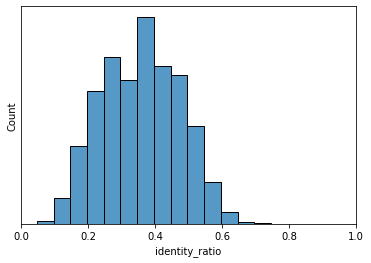

In [80]:
sns.histplot(rd5_pairs['identity_ratio'], binwidth=0.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])
plt.savefig('../figures/rd5all_med_seq_id.svg')

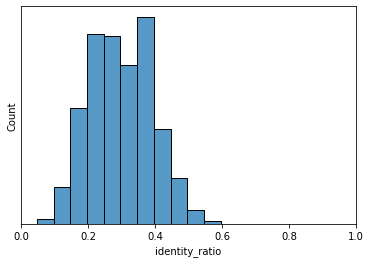

In [81]:
sns.histplot(rd6_pairs['identity_ratio'], binwidth=0.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])
plt.savefig('../figures/rd6all_med_seq_id.svg')

In [18]:
# find median for all rd5 or rd6 pairs
np.median(rd5_pairs['identity_ratio']), np.median(rd6_pairs['identity_ratio'])

(0.3488372093023256, 0.27906976744186046)

In [19]:

def stable_pairs(df, stable_df):
    ''' subset the pairs df to only stable designs '''
    merge_df = pd.merge(left=df, right=stable_df, left_on='design1', right_on='name', how='inner')
    merge_df2 = pd.merge(left=merge_df, right=stable_df, left_on='design2', right_on='name', how='inner')
    return merge_df2

In [20]:
rd5_stable_pairs=stable_pairs(df=rd5_pairs, stable_df=rd5_stable[['name', 'cat']])
rd6_stable_pairs=stable_pairs(df=rd6_pairs, stable_df=rd6_stable[['name', 'cat']])

In [21]:
rd5_stable_pairs

,design1,design2,seq1,seq2,identity_ratio,name_x,cat_x,name_y,cat_y
0,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0002.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,DIEELIRLLEEALRKNQSITILGFEVRHEEEFEHLLRILRELL,0.232558,HEEH_TK_rd5_0001.pdb,design,HEEH_TK_rd5_0002.pdb,design
1,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0003.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,TLEELLKEAERLLREGHSLHIAGIEIRDEEELRKAFEWLRRWL,0.325581,HEEH_TK_rd5_0001.pdb,design,HEEH_TK_rd5_0003.pdb,design
2,HEEH_TK_rd5_0002.pdb,HEEH_TK_rd5_0003.pdb,DIEELIRLLEEALRKNQSITILGFEVRHEEEFEHLLRILRELL,TLEELLKEAERLLREGHSLHIAGIEIRDEEELRKAFEWLRRWL,0.372093,HEEH_TK_rd5_0002.pdb,design,HEEH_TK_rd5_0003.pdb,design
3,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0004.pdb,SLEELLRLAEELLRNGQSIHILGIEVRREEEAEELLRLLRRLI,TEEDLLELLREALRKGEEITIAGIRVTNEEAFEELLRWLEKWI,0.209302,HEEH_TK_rd5_0001.pdb,design,HEEH_TK_rd5_0004.pdb,design
4,HEEH_TK_rd5_0002.pdb,HEEH_TK_rd5_0004.pdb,DIEELIRLLEEALRKNQSITILGFEVRHEEEFEHLLRILRELL,TEEDLLELLREALRKGEEITIAGIRVTNEEAFEELLRWLEKWI,0.488372,HEEH_TK_rd5_0002.pdb,design,HEEH_TK_rd5_0004.pdb,design
...,...,...,...,...,...,...,...,...,...
2284448,HEEH_TK_rd5_5970.pdb,HEEH_TK_rd5_5991.pdb,HLEEIIRKAEELLKRGEDIHIAGIRITDEEALKRAAEWLKRHI,DEEDFKRWLEHALKRGQDIHLFGWTIKSEDEARKILEWLKRFV,0.465116,HEEH_TK_rd5_5970.pdb,design,HEEH_TK_rd5_5991.pdb,design
2284449,HEEH_TK_rd5_5975.pdb,HEEH_TK_rd5_5991.pdb,DLEEIKRIIDEALEKGEDITIAGIRITTEEEAKKAKEWFEREI,DEEDFKRWLEHALKRGQDIHLFGWTIKSEDEARKILEWLKRFV,0.302326,HEEH_TK_rd5_5975.pdb,design,HEEH_TK_rd5_5991.pdb,design
2284450,HEEH_TK_rd5_5976.pdb,HEEH_TK_rd5_5991.pdb,HLREIEEEIKEALKRNETFHFAGIEVRSEEDLERFIRILEKRI,DEEDFKRWLEHALKRGQDIHLFGWTIKSEDEARKILEWLKRFV,0.418605,HEEH_TK_rd5_5976.pdb,design,HEEH_TK_rd5_5991.pdb,design
2284451,HEEH_TK_rd5_5977.pdb,HEEH_TK_rd5_5991.pdb,TLEEIEKIAKEALKRGETVRIAGFEVRDEEEARKLLEWFRRLF,DEEDFKRWLEHALKRGQDIHLFGWTIKSEDEARKILEWLKRFV,0.395349,HEEH_TK_rd5_5977.pdb,design,HEEH_TK_rd5_5991.pdb,design


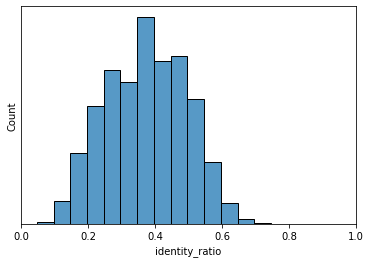

In [82]:
sns.histplot(rd5_stable_pairs['identity_ratio'], binwidth=0.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])
plt.savefig('../figures/rd5stable_med_seq_id.svg')

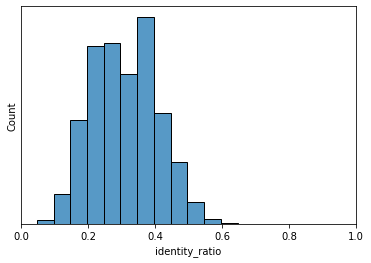

In [83]:
sns.histplot(rd6_stable_pairs['identity_ratio'], binwidth=0.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])
plt.savefig('../figures/rd6stable_med_seq_id.svg')

In [22]:
# find median for all stable rd5 or rd6 pairs
np.median(rd5_stable_pairs['identity_ratio']), np.median(rd6_stable_pairs['identity_ratio'])  

(0.37209302325581395, 0.3023255813953488)

## pairwise analysis for hphob residues

In [23]:
rd5_hphob = rd5[['name', 'sequence', 'stabilityscore']]
rd6_hphob = rd6[['name', 'sequence', 'stabilityscore']]

In [24]:
def edit_sequence_list(df):
    ''' edit aa sequence by putting X for all non-hphob residues'''
    seq_hphob = []

    for seq in df['sequence']:
        edited_seq = ''
        for res in seq:
            if res in 'AFILMWVY':
                edited_seq += res
            else:
                edited_seq += 'X'
        seq_hphob.append(edited_seq)
    df['edit_seq'] = seq_hphob
    return df

In [25]:
rd5_hphob=edit_sequence_list(df=rd5_hphob)
rd6_hphob=edit_sequence_list(df=rd6_hphob)

/var/folders/35/r7mlztxx5bj0x1y0f49pww80cq0ykg/T/ipykernel_16204/2787245059.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['edit_seq'] = seq_hphob


In [26]:
def df_hphob_pairwise(df):
    ''' return df with all pariwise edited sequences and their design names '''
    seq_pairs_list = list(itertools.combinations(df['edit_seq'], 2))
    names_pairs_list = list(itertools.combinations(df['name'], 2))
    
    new_df1 = pd.DataFrame(names_pairs_list, columns = ['design1' ,'design2'])
    new_df2 = pd.DataFrame(seq_pairs_list, columns = ['edit_seq1' ,'edit_seq2'])
    combine_df = pd.concat([new_df1, new_df2], axis=1)
    return combine_df

In [27]:
rd5_pairs2=df_hphob_pairwise(df=rd5_hphob)
rd6_pairs2=df_hphob_pairwise(df=rd6_hphob)

In [64]:
rd5_pairs2

,design1,design2,edit_seq1,edit_seq2,edit_seq1v2,edit_seq2v2,hphob_identity_ratio
0,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0002.pdb,XLXXLLXLAXXLLXXXXXIXILXIXVXXXXXAXXLLXLLXXLI,XIXXLIXLLXXALXXXXXIXILXFXVXXXXXFXXLLXILXXLL,LLLLALLIILIVALLLLLI,ILILLALIILFVFLLILLL,0.631579
1,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0003.pdb,XLXXLLXLAXXLLXXXXXIXILXIXVXXXXXAXXLLXLLXXLI,XLXXLLXXAXXLLXXXXXLXIAXIXIXXXXXLXXAFXWLXXWL,LLLLALLIILIVALLLLLI,LLLXALLLIAIILAFWLWL,0.473684
2,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0004.pdb,XLXXLLXLAXXLLXXXXXIXILXIXVXXXXXAXXLLXLLXXLI,XXXXLLXLLXXALXXXXXIXIAXIXVXXXXAFXXLLXWLXXWI,LLLLALLIILIVXALLLLLI,XLLLLALIIAIVAFLLWLWI,0.750000
3,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0005.pdb,XLXXLLXLAXXLLXXXXXIXILXIXVXXXXXAXXLLXLLXXLI,XIXXLLXXIXXLLXXXIXFXWAXIXIXXXXXAXXILXXLXXLL,LLLLALLXIILIVALLLLLI,ILLXILLIFWAIIAILXLLL,0.450000
4,HEEH_TK_rd5_0001.pdb,HEEH_TK_rd5_0006.pdb,XLXXLLXLAXXLLXXXXXIXILXIXVXXXXXAXXLLXLLXXLI,XFXXLLXLLXXAWXXXXXIXILXFXVXXXXXAXXLLXWLXXWI,LLLLALLIILIVALLLLLI,FLLLLAWIILFVALLWLWI,0.736842
...,...,...,...,...,...,...,...
15778148,HEEH_TK_rd5_5996.pdb,HEEH_TK_rd5_5998.pdb,XXXXWXXILXXAIXXXXXFXVFXLXVXXXXAAXXXAXWLXXFX,XXXXIXXALXIAXXAXXXVXVAXFXIXXXXAAXXALXWWXXXV,WILXAIXFVFLVAAXAWLFX,IALIAXAVVAFIAAALWWXV,0.400000
15778149,HEEH_TK_rd5_5996.pdb,HEEH_TK_rd5_5999.pdb,XXXXWXXILXXAIXXXXXFXVFXLXVXXXXAAXXXAXWLXXFX,XXXXIXXIIXXAIXLXXXVXVAXFXVXXXXXAXXIIXXLXXII,WILAIXFVFLVAAXAWLFX,IIIAILVVAFVXAIIXLII,0.315789
15778150,HEEH_TK_rd5_5997.pdb,HEEH_TK_rd5_5998.pdb,XXXXLXXXIXXXLXXXXXVXLFXVXVXXXXLAXXLLXIIXXLX,XXXXIXXALXIAXXAXXXVXVAXFXIXXXXAAXXALXWWXXXV,LXIXXLXVLFVVLALLIILX,IALIAXAVVAFIAAALWWXV,0.300000
15778151,HEEH_TK_rd5_5997.pdb,HEEH_TK_rd5_5999.pdb,XXXXLXXXIXXXLXXXXXVXLFXVXVXXXXLAXXLLXIIXXLX,XXXXIXXIIXXAIXLXXXVXVAXFXVXXXXXAXXIIXXLXXII,LXIXLXVLFVVLALLIILX,IIIAILVVAFVXAIIXLII,0.368421


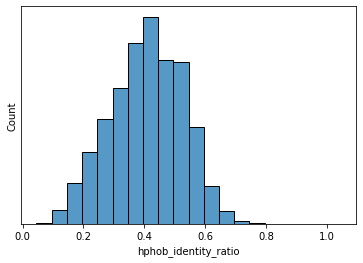

In [84]:
sns.histplot(rd5_pairs2['hphob_identity_ratio'], binwidth=0.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])
plt.savefig('../figures/rd5allhphob_med_seq_id.svg')

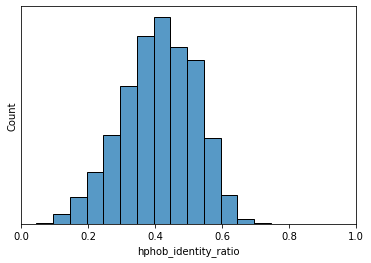

In [85]:
sns.histplot(rd6_pairs2['hphob_identity_ratio'], binwidth=0.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])
plt.savefig('../figures/rd6allhphob_med_seq_id.svg')

In [29]:
def keep_hphob_sequence(df):
    '''loop through all sequence pairs and keep sequences whose paired positions have hphob residue (one or both)'''
    edit_seq1 = df['edit_seq1']
    edit_seq2 = df['edit_seq2']
    
    new_edit_seq1 = []
    new_edit_seq2 = []
    
    for seq1, seq2 in zip(edit_seq1, edit_seq2):
        new_seq1 = ''
        new_seq2 = ''
        for res1, res2 in zip(seq1, seq2):
            if res1 in 'AFILMWVY' or res2 in 'AFILMWVY':
                new_seq1+=res1
                new_seq2+=res2
        new_edit_seq1.append(new_seq1)
        new_edit_seq2.append(new_seq2)
    
    df['edit_seq1v2'] = new_edit_seq1
    df['edit_seq2v2'] = new_edit_seq2
    return df

In [30]:
rd5_pairs2 = keep_hphob_sequence(df=rd5_pairs2)
rd6_pairs2 = keep_hphob_sequence(df=rd6_pairs2)

In [31]:
def pairwise_hphob_identity(df):
    ''' calculate sequence identity for all pairs, returns a list of all hphbob identities '''
    seq1 = df['edit_seq1v2']
    seq2 = df['edit_seq2v2']
    all_identities = []
    
    for one, two in zip(seq1, seq2):
        pairwise_identity = SequenceMatcher(a=one, b=two)
        all_identities.append(pairwise_identity.ratio())
    df['hphob_identity_ratio'] = all_identities
    return df

In [32]:
rd5_pairs2=pairwise_hphob_identity(df=rd5_pairs2)
rd6_pairs2=pairwise_hphob_identity(df=rd6_pairs2)

In [33]:
def stable_hphob_pairs(df, stable_df):
    ''' subset the pairs df to only stable designs '''
    merge_df = pd.merge(left=df, right=stable_df, left_on='design1', right_on='name', how='inner')
    merge_df2 = pd.merge(left=merge_df, right=stable_df, left_on='design2', right_on='name', how='inner')
    return merge_df2

In [34]:
rd5_stable_hphob_pairs=stable_hphob_pairs(df=rd5_pairs2, stable_df=rd5_stable[['name', 'cat']])
rd6_stable_hphob_pairs=stable_hphob_pairs(df=rd6_pairs2, stable_df=rd6_stable[['name', 'cat']])

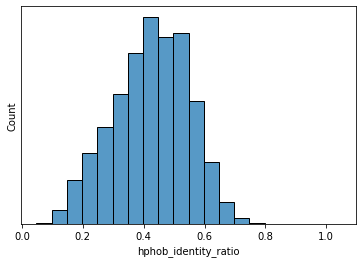

In [86]:
sns.histplot(rd5_stable_hphob_pairs['hphob_identity_ratio'], binwidth=0.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])
plt.savefig('../figures/rd5stablehphob_med_seq_id.svg')

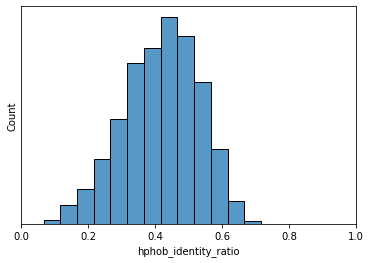

In [87]:
sns.histplot(rd6_stable_hphob_pairs['hphob_identity_ratio'], binwidth=0.05)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])
plt.savefig('../figures/rd6stablehphob_med_seq_id.svg')

In [35]:
# find median for all rd5 or rd6 pairs
np.median(rd5_pairs2['hphob_identity_ratio']), np.median(rd6_pairs2['hphob_identity_ratio'])

(0.4117647058823529, 0.4166666666666667)

In [36]:
# find median for all stable rd5 or rd6 pairs
np.median(rd5_stable_hphob_pairs['hphob_identity_ratio']), np.median(rd6_stable_hphob_pairs['hphob_identity_ratio'])

(0.42105263157894735, 0.42424242424242425)

### plot all median pairwise identities

In [40]:
rd5_pairs['identity_ratio']

0           0.232558
1           0.325581
2           0.209302
3           0.511628
4           0.697674
              ...   
15778148    0.488372
15778149    0.418605
15778150    0.209302
15778151    0.232558
15778152    0.558140
Name: identity_ratio, Length: 15778153, dtype: float64

In [37]:
median_rd5 = np.median(rd5_pairs['identity_ratio'])
median_rd6 = np.median(rd6_pairs['identity_ratio'])
median_stable_rd5 = np.median(rd5_stable_pairs['identity_ratio'])
median_stable_rd6 = np.median(rd6_stable_pairs['identity_ratio'])

median_hphob_rd5 = np.median(rd5_pairs2['hphob_identity_ratio'])
median_hphob_rd6 = np.median(rd6_pairs2['hphob_identity_ratio'])
median_stable_hphob_rd5 = np.median(rd5_stable_hphob_pairs['hphob_identity_ratio'])
median_stable_hphob_rd6 = np.median(rd6_stable_hphob_pairs['hphob_identity_ratio'])

In [97]:
median_stable_hphob_rd6

0.42424242424242425

In [88]:
median_hphob_rd6

0.4166666666666667

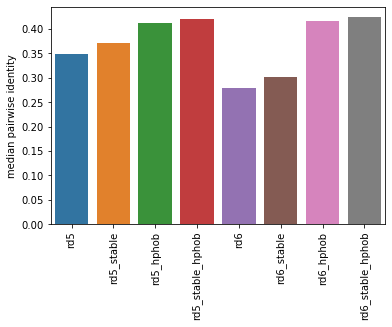

In [38]:
sns.barplot(x=['rd5', 'rd5_stable', 'rd5_hphob', 'rd5_stable_hphob', 'rd6', 'rd6_stable', 'rd6_hphob', 'rd6_stable_hphob'],
           y=[median_rd5, median_stable_rd5, median_hphob_rd5, median_stable_hphob_rd5, median_rd6, median_stable_rd6, 
             median_hphob_rd6, median_stable_hphob_rd6])
plt.xticks(rotation=90)
plt.ylabel('median pairwise identity')
plt.savefig('median_pairwise_id.svg')

In [322]:
len(rd5_pairs), len(rd5_stable_pairs), len(rd5_pairs2), len(rd5_stable_hphob_pairs)

(15778153, 2284453, 15778153, 2284453)

In [330]:
len(np.unique(rd5_stable_hphob_pairs['design1']))

2137

In [332]:
len(np.unique(rd5_pairs2['design2']))

5617